### PFSS modeling with pfsspy

Tamar Ervin - September 19, 2022

Based off example notebook: Sam Badman - 8/25/22

This notebook goes through running a potential field source surface (PFSS, [1](https://ui.adsabs.harvard.edu/abs/1969SoPh....9..131A/abstract),[2](https://ui.adsabs.harvard.edu/abs/1969SoPh....6..442S/abstract)) model of the solar coronal magnetic field using pfsspy and accessing its components including tracing fieldlines, creating a map of coronal holes and flying a model spacecraft through it and tracing field line connections

Read more about pfsspy here : https://pfsspy.readthedocs.io/en/stable/ and view the source code here : https://github.com/dstansby/pfsspy/tree/0c5b78a2901c5dd55ddc286ba25a91717e85a40c

In [14]:
import astropy
import sunpy, sunpy.map
import pfsspy
import matplotlib.pyplot as plt
import numpy as np

import sys, os

sys.path.append(os.path.realpath(''))
# sys.path.append('/Users/tamarervin/Desktop/Repositories/mag_model/')
import utilities as utils
import psp_funcs as psp_funcs
import pfss_funcs as pfss_funcs


In [15]:
rss = 2.5
IMG_DIR = os.path.realpath('../mag_model/images')
print(IMG_DIR)


/Users/tamarervin/Desktop/Repositories/mag_model/images


# Looking at PSP Data
- read in the PSP text file with timestamps and $\mathrm{B_r \, AU^2}$ values
- use to compare with data to find a 'best' magnetogram
- pull the polarity to overlay on the plot

In [16]:
# read in the PSP text file and convert to a pandas dataframe
import pandas as pd

psp_txt_file = '/Users/tamarervin/Desktop/Repositories/mag_model/data/psp/BrAU2_mode.txt'
psp_data = pd.read_csv(psp_txt_file, sep='      ', names=['datetime', 'Br'], engine='python')

# split the datetime column into a separate date and time column
psp_data[['date', 'time']] = psp_data.datetime.str.split('/', expand=True)
dates = psp_data.date + 'T' + psp_data.time

# convert datetime to a JD date and datetime object -- use the conversion function in utilities.py
dates_list = [utils.get_dates(date) for date in dates]
jd_dates = [d[2] for d in dates_list]
jd_dates = [d.to_value('jd', 'long') for d in jd_dates]
psp_data['jd'] = jd_dates
psp_data['date_obj'] = [d[1] for d in dates_list]

# add a polarity column
psp_data['polarity'] = np.sign(psp_data.Br)

# look at the data frame
psp_data


,datetime,Br,date,time,jd,date_obj,polarity
0,2022-09-01/00:12:58.760,-3.40,2022-09-01,00:12:58.760,2.459824e+06,2022-09-01 00:12:58.760,-1.0
1,2022-09-01/00:27:58.760,-2.48,2022-09-01,00:27:58.760,2.459824e+06,2022-09-01 00:27:58.760,-1.0
2,2022-09-01/00:42:58.760,-3.60,2022-09-01,00:42:58.760,2.459824e+06,2022-09-01 00:42:58.760,-1.0
3,2022-09-01/00:57:58.760,-3.48,2022-09-01,00:57:58.760,2.459824e+06,2022-09-01 00:57:58.760,-1.0
4,2022-09-01/01:12:58.760,-3.40,2022-09-01,01:12:58.760,2.459824e+06,2022-09-01 01:12:58.760,-1.0
...,...,...,...,...,...,...,...
1049,2022-09-11/22:27:58.760,-3.80,2022-09-11,22:27:58.760,2.459834e+06,2022-09-11 22:27:58.760,-1.0
1050,2022-09-11/22:42:58.760,-3.64,2022-09-11,22:42:58.760,2.459834e+06,2022-09-11 22:42:58.760,-1.0
1051,2022-09-11/22:57:58.760,-3.72,2022-09-11,22:57:58.760,2.459834e+06,2022-09-11 22:57:58.760,-1.0
1052,2022-09-11/23:12:58.760,-3.52,2022-09-11,23:12:58.760,2.459834e+06,2022-09-11 23:12:58.760,-1.0


In [17]:
# remove the data from september 5 due to the solar flare -- set up a flag column
date_str, date_obj, date_jd = utils.get_dates('2022-09-05T00:00:00.000')
flag_inds = np.logical_and(psp_data.date >= date_jd - 0.2, psp_data.date <= date_jd + 1)
flag = np.array(['' for x in range(len(psp_data.datetime))])
flag[flag_inds] = 'flare'
psp_data['flag'] = flag
psp_data

,datetime,Br,date,time,jd,date_obj,polarity,flag
0,2022-09-01/00:12:58.760,-3.40,2022-09-01,00:12:58.760,2.459824e+06,2022-09-01 00:12:58.760,-1.0,
1,2022-09-01/00:27:58.760,-2.48,2022-09-01,00:27:58.760,2.459824e+06,2022-09-01 00:27:58.760,-1.0,
2,2022-09-01/00:42:58.760,-3.60,2022-09-01,00:42:58.760,2.459824e+06,2022-09-01 00:42:58.760,-1.0,
3,2022-09-01/00:57:58.760,-3.48,2022-09-01,00:57:58.760,2.459824e+06,2022-09-01 00:57:58.760,-1.0,
4,2022-09-01/01:12:58.760,-3.40,2022-09-01,01:12:58.760,2.459824e+06,2022-09-01 01:12:58.760,-1.0,
...,...,...,...,...,...,...,...,...
1049,2022-09-11/22:27:58.760,-3.80,2022-09-11,22:27:58.760,2.459834e+06,2022-09-11 22:27:58.760,-1.0,
1050,2022-09-11/22:42:58.760,-3.64,2022-09-11,22:42:58.760,2.459834e+06,2022-09-11 22:42:58.760,-1.0,
1051,2022-09-11/22:57:58.760,-3.72,2022-09-11,22:57:58.760,2.459834e+06,2022-09-11 22:57:58.760,-1.0,
1052,2022-09-11/23:12:58.760,-3.52,2022-09-11,23:12:58.760,2.459834e+06,2022-09-11 23:12:58.760,-1.0,


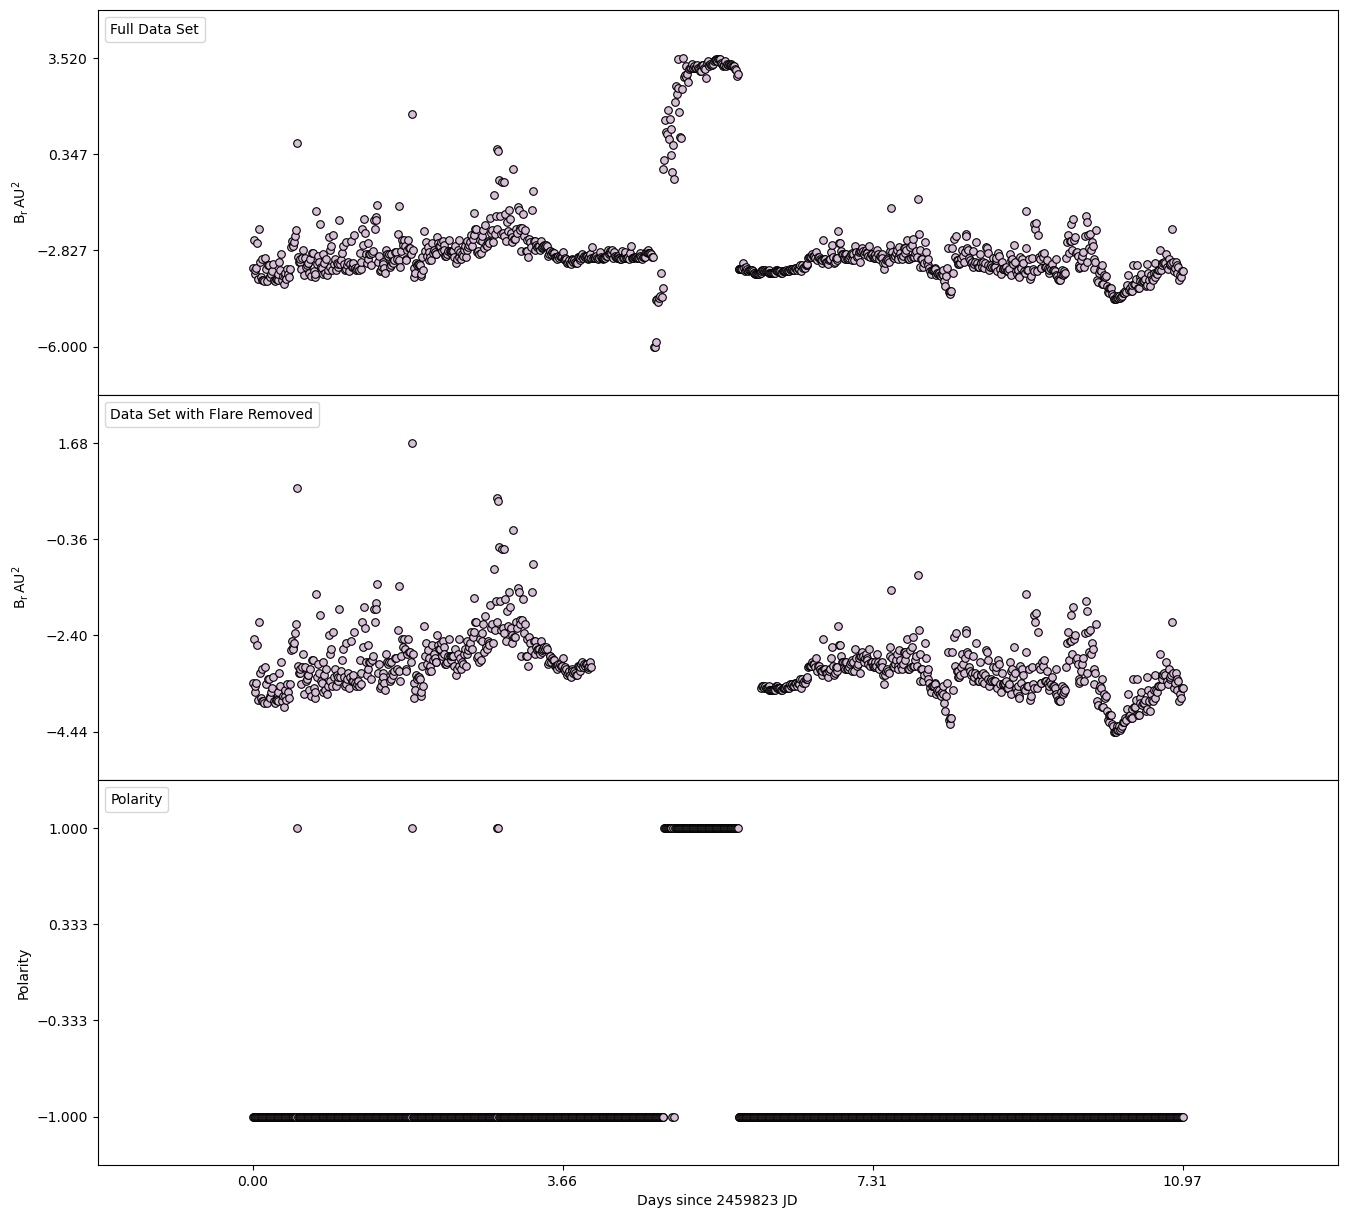

In [18]:
# plot the magnetic field data to look at it -- we expect a big spike on Sept 5 due to a solar flare
 
# get a list of data that is unflagged (no flare)
good_inds = np.where(psp_data.flag == '')
good_br = psp_data.Br[good_inds[0]]

# get dates list
date_jd = psp_data.jd.values
x = date_jd - date_jd[0]

# lists of data
x_list = [x, x[good_inds], x]
y_list = [psp_data.Br, good_br, psp_data.polarity]
xlabel = 'Days since ' + str(int(date_jd[0])) + ' JD'
ylabel_list = [r'$\rm B_r \, AU^2$', r'$\rm B_r \, AU^2$', 'Polarity']
labels_list = ['Full Data Set', 'Data Set with Flare Removed', 'Polarity']
fig, axs = plt.subplots(len(y_list), 1, sharex='all', figsize=[16, 5 * len(y_list)], gridspec_kw={'hspace': 0})


# create y-ticks and label 
for i in range(0, len(axs)):
    axs[i].set(ylabel=ylabel_list[i])
    rng = (y_list[i].max() - y_list[i].min())
    step = rng/6
    ylim = (y_list[i].min() - step, y_list[i].max() + step)
    yticks = np.arange(y_list[i].min(), y_list[i].max()+0.0002, step=step*2)
    axs[i].set(ylim=ylim, yticks=yticks)

# create x-ticks and label
axs[i].set(xlabel=xlabel)
rng = (x.max() - x.min())
step = rng/6
xlim = (x.min() - step, x.max() + step)
xticks = np.arange(x.min(), x.max()+.001, step=step*2)
axs[i].set(xlim=xlim, xticks=xticks)

# plot data
for i in range(0, len(axs)):
    axs[i].scatter(x_list[i], y_list[i], color='thistle', s=30, edgecolors='k', linewidths=0.8,
                   label=labels_list[i])

    # draw legend
    leg = axs[i].legend(handlelength=0, handletextpad=0, loc='upper left')
    for item in leg.legendHandles:
        item.set_visible(False)


# align y axis labels
fig.align_ylabels(axs)

# Find the trajectory of PSP using astrospice and timestamps above

In [20]:
# get the corresponding coordinates to the timestamps in the dataframe
# psp_coords_carr = psp_funcs.get_psp_coords(psp_data.date_obj)
import astrospice

kernels = astrospice.registry.get_kernels('psp', 'predict')
psp_coords_inertial = astrospice.generate_coords('SOLAR PROBE PLUS', psp_data.date_obj)

# Transform to Heliographic Carrington, i.e. the frame that co-rotates with the Sun.
psp_coords_carr = psp_coords_inertial.transform_to(
sunpy.coordinates.HeliographicCarrington(observer="self")
)

# add these to the dataframe
psp_data['carr'] = psp_coords_carr

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [21]:
# do the parker spiral projection to get the coordinates at the source surface
psp_at_source_surface = psp_funcs.coord_projection(psp_coords_carr, rss, psp_data.date_obj)


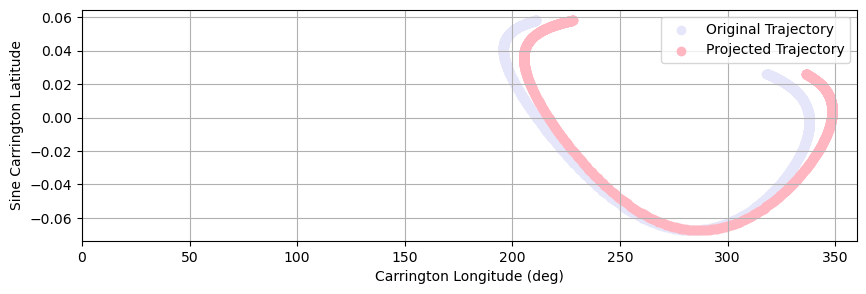

In [22]:
fig,ax = plt.subplots(figsize=(10,3))

psp_coords_carr.representation_type="spherical"
ax.scatter(psp_coords_carr.lon, np.sin(psp_coords_carr.lat), color='lavender', label="Original Trajectory")
ax.scatter(psp_at_source_surface.lon, np.sin(psp_at_source_surface.lat), color='lightpink',
 label="Projected Trajectory")

ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(0,360)

ax.grid()

ax.legend()

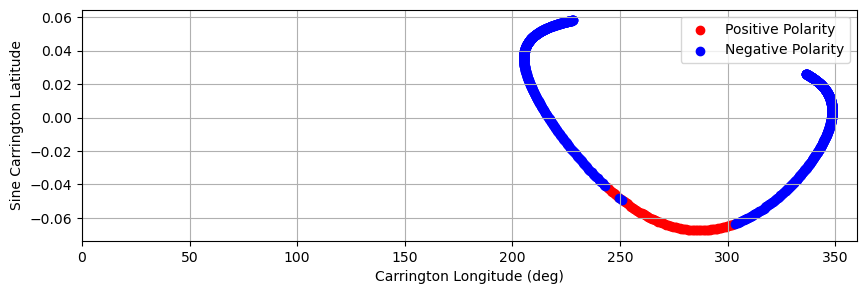

In [23]:
# plot the trajectory with the polarity
# find where the polarity is positive 
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)
fig,ax = plt.subplots(figsize=(10,3))

ax.scatter(psp_at_source_surface.lon[pos], np.sin(psp_at_source_surface.lat[pos]), color='red', 
label='Positive Polarity')
ax.scatter(psp_at_source_surface.lon[neg], np.sin(psp_at_source_surface.lat[neg]), color='blue',
label='Negative Polarity')

ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(0,360)

ax.grid()

ax.legend()

# create $\mathrm{B_rR^2}$ map
- create the PFSS model for one magnetogram at perihelion 
- run the PSP trajectory over the PFSS model and trace the field lines back down to the source surface using parker spiral
- get the Br values at the source surface from the PFSS model

In [24]:
# get a magnetogram for the specific date and time in question
filenames = ["adapt41311_03k012_202209190600_i00030500n1.fts.gz", 'adapt41311_03k012_202209190000_i00005600n1.fts.gz']


In [25]:
filename = filenames[1]
remote_path = "ftp://gong.nso.edu//adapt/maps/gong/2022"
local_path = "data/gong"
if not os.path.exists(f"{local_path}/{filename}") : # check if file has already been downloaded
    print(f"Downloading {local_path}/{filename}") 
    os.system(f'wget {remote_path}/{filename} -P {local_path}')
else : print(f"{local_path}/{filename} already exists!" )


data/gong/adapt41311_03k012_202209190000_i00005600n1.fts.gz already exists!


In [26]:
# get an adapt magnetogram
filepath = f"{local_path}/{filename}"
adapt_magnetogram = pfss_funcs.adapt2pfsspy(filepath, return_magnetogram=True)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]


In [27]:
# run the PFSS model with rss 
pfss_model = pfss_funcs.adapt2pfsspy(filepath, rss)

# magnetic field line tracing starting from photosphere
flines = pfss_funcs.pfss2flines(pfss_model)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: dsun_obs,hgln_obs,hglt_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs,dsun_obs
 [sunpy.map.mapbase]
/opt/anaconda3/envs/mag_model/lib/python3.8/site-packages/pfsspy/tracing.py:180: UserWarning: At least one field line ran out of steps during tracing.
You should probably increase max_steps (currently set to 1000) and try again.
  warnings.warn(


In [ ]:
import astropy.units as u

# get Br at the source surface from the pfss model
pfss_br = pfss_model.source_surface_br

# get HCS
hcs = pfss_model.source_surface_pils[0]

# plot this using sunpy
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
# pfss_br.plot(axes=ax)

# plot the HCS
ax.scatter(hcs.lon, hcs.lat, color='black', s=3, label='HCS')

# plot the PSP trajectory on top of it
pos = np.where(psp_data.polarity == 1)
neg = np.where(psp_data.polarity == -1)

ax.scatter(psp_at_source_surface.lon[neg], psp_at_source_surface.lat[neg], color='blue', s=10,
label='Negative Polarity')
ax.scatter(psp_at_source_surface.lon[pos], psp_at_source_surface.lat[pos], color='red', s=10, 
label='Positive Polarity')

ax.set_title(str(pfss_br.date)[:-4] + r" $\rm R_{ss} =$" + str(rss))
ax.set_xlabel("Carrington Longitude (deg)")
ax.set_ylabel("Sine Carrington Latitude")

ax.set_xlim(0,360)
ax.legend(loc='lower right')

fig_title = str(pfss_br.date) + '_' + str(rss) + '.png'
figpath = os.path.join(IMG_DIR, fig_title)
fig.savefig(figpath, dpi=1200, bbox_inches='tight')

In [ ]:
# get the radial data from stuart
# make the heliospheric current sheet on the 2D grid of Br -- contour where Br at SS is 0
# plot the PSP trajectory across the Br grid 
# use the timeseries from the data on the astrospice thing to get the actual 
#       PSP coordinates for comparison

# goals
- find good magnetogram
- change the Rss surface height

- want to create a csv file with HCS data, PSP data